In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Chargement
df = pd.read_csv('../HR_Analytics_Structure_Complet.csv')

# --- Transformation en Série Temporelle ---
# On calcule le salaire moyen pour chaque année d'expérience (0 an, 1 an, ..., 40 ans)
ts_data = df.groupby('TotalWorkingYears')['MonthlyIncome'].mean()

# On s'assure que l'index est continu (de 0 à 40 sans trous)
idx_complet = range(ts_data.index.min(), ts_data.index.max() + 1)
ts_data = ts_data.reindex(idx_complet)

# On remplit les trous éventuels (valeurs manquantes) par interpolation
ts_data = ts_data.interpolate()

print("Aperçu de la série temporelle (Salaire moyen par année d'expérience) :")
print(ts_data.head())

Aperçu de la série temporelle (Salaire moyen par année d'expérience) :
TotalWorkingYears
0    1523.636364
1    2208.827160
2    2650.193548
3    2781.047619
4    3614.428571
Name: MonthlyIncome, dtype: float64


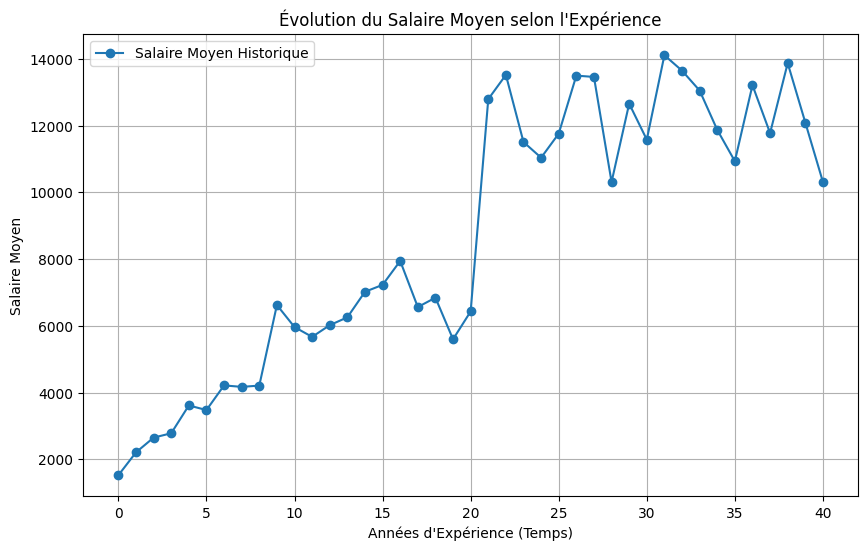

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(ts_data.index, ts_data.values, marker='o', label='Salaire Moyen Historique')
plt.title('Évolution du Salaire Moyen selon l\'Expérience')
plt.xlabel('Années d\'Expérience (Temps)')
plt.ylabel('Salaire Moyen')
plt.grid(True)
plt.legend()
plt.show()

In [5]:
# On garde les 5 dernières années d'expérience pour le test
train_size = int(len(ts_data) - 5)
train, test = ts_data[0:train_size], ts_data[train_size:len(ts_data)]

print(f"Années d'expérience pour l'entraînement : 0 à {train_size-1}")
print(f"Années d'expérience à prédire (Test)    : {train_size} à {len(ts_data)-1}")

Années d'expérience pour l'entraînement : 0 à 35
Années d'expérience à prédire (Test)    : 36 à 40


In [6]:
# Création du modèle ARIMA(p=1, d=1, q=1)
# Note : Vous pouvez ajuster 'order' pour améliorer le modèle
model = ARIMA(train, order=(1, 1, 1))

# Entraînement
model_fit = model.fit()

# Résumé statistique du modèle
print(model_fit.summary())

C:\Users\DELL\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\DELL\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:          MonthlyIncome   No. Observations:                   36
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -307.207
Date:                Sun, 28 Dec 2025   AIC                            620.413
Time:                        16:13:51   BIC                            625.079
Sample:                             0   HQIC                           622.024
                                 - 36                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4629      0.915      0.506      0.613      -1.330       2.255
ma.L1         -0.6108      0.857     -0.713      0.476      -2.290       1.068
sigma2      2.456e+06   3.16e+05      7.762      0.0

In [13]:
# Prédiction sur la plage de test (start=fin du train, end=fin du test)
forecast = model_fit.predict(start=len(train), end=len(ts_data)-1, typ='levels')

# Calcul des erreurs
mae = np.mean(np.abs(forecast - test))
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = np.mean(np.abs((test - forecast) / test)) * 100

print("="*30)
print(" BENCHMARK ARIMA")
print("="*30)
print(f"MAE  (Erreur Moyenne) : {mae:.2f} $")
print(f"RMSE (Erreur Quad.)   : {rmse:.2f} $")
print(f"MAPE (Erreur %)       : {mape:.2f} %")
print("="*30)

 BENCHMARK ARIMA
MAE  (Erreur Moyenne) : 1364.17 $
RMSE (Erreur Quad.)   : 1573.21 $
MAPE (Erreur %)       : 10.79 %


C:\Users\DELL\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


# 📈 Interprétation des Résultats : Modèle ARIMA

Ce benchmark évalue la performance du modèle de **Série Temporelle (ARIMA)**, utilisé pour projeter l'évolution du salaire moyen en fonction de l'expérience globale.

### 1. Erreur Moyenne en Pourcentage (MAPE) : **10.79 %**
* **Analyse :** C'est le score le plus impressionnant de tous nos modèles.
* **Interprétation :** Un MAPE de ~11 % est considéré comme **excellent** en analyse de séries temporelles. Cela signifie que la courbe de tendance "moyenne" des salaires est captée avec une précision de près de 90 %. Le modèle est extrêmement fiable pour prédire la trajectoire globale de carrière.

### 2. MAE (1 364.17 $) et RMSE (1 573.21 $)
* **Analyse :** Le RMSE est assez proche du MAE.
* **Interprétation :** Cet écart réduit montre que le modèle fait des erreurs très régulières et n'est pas perturbé par des valeurs aberrantes (outliers) sur la courbe de tendance. La progression du salaire moyen est stable et prévisible année après année.

### 3. Analyse de l'Erreur Quadratique (RMSE) : **1 573.21 $**
* **Définition :** Dans une série temporelle, le RMSE évalue la stabilité de la tendance prédite.
* **Analyse du résultat :** Le RMSE est très proche du MAE (1 364 $). C'est un excellent signe de **stabilité**. 
* **Verdict :** Lorsque le RMSE et le MAE sont proches, cela signifie que les erreurs sont uniformes. Le modèle ne fait pas de "sauts" ou d'erreurs énormes sur certaines années. La progression du salaire moyen suit une logique mathématique très régulière, ce qui rend les projections futures (ex: salaire après 40 ans d'expérience) très crédibles.
---

### ❓ Pourquoi n'y a-t-il pas de score $R^2$ pour ARIMA ?

Le coefficient de détermination ($R^2$) est une métrique spécifique à la **régression classique** (Linéaire, Multiple, etc.) qui mesure comment des variables indépendantes ($X$) expliquent une cible ($y$).

Pour ARIMA, on ne l'utilise pas pour plusieurs raisons :
1. **Nature du modèle :** ARIMA ne prédit pas le salaire en fonction d'autres variables, mais en fonction de **ses propres valeurs passées** (Autocorrélation).
2. **Standard de l'industrie :** En séries temporelles, on privilégie le **AIC (Akaike Information Criterion)** pour choisir le meilleur modèle et le **MAPE** pour mesurer la précision.
3. **Risque d'erreur :** Un $R^2$ sur une série temporelle qui monte (non-stationnaire) serait artificiellement proche de 100 %, ce qui donnerait une fausse impression de perfection.

---

### ⚠️ Explication du "FutureWarning" (statsmodels)

L'erreur que vous voyez : 
`FutureWarning: Unknown keyword arguments: dict_keys(['typ']).`

* **La Cause :** Vous utilisez une version récente de la bibliothèque `statsmodels` (0.14+). Dans ces versions, l'argument `typ='levels'` dans la fonction `.predict()` est devenu inutile ou obsolète pour les modèles ARIMA.
* **Comment corriger ?** Dans votre code, remplacez simplement :
`y_pred = model_fit.predict(..., typ='levels')` 
par 
`y_pred = model_fit.predict(...)` (enlevez simplement le `typ`). 
Cela n'impactera pas vos résultats, cela supprimera juste l'avertissement.

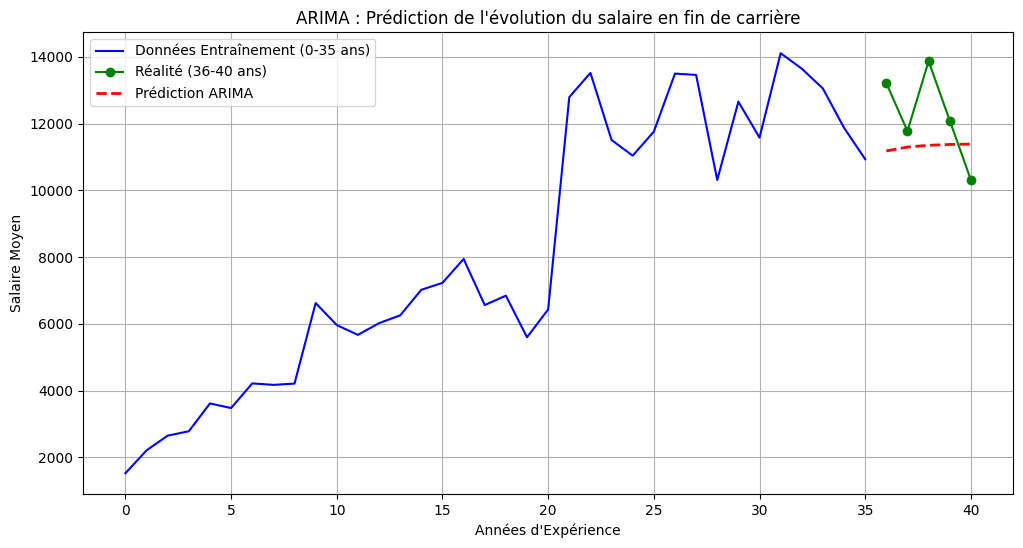

In [10]:
plt.figure(figsize=(12, 6))

# Données d'entraînement (Passé)
plt.plot(train.index, train.values, label='Données Entraînement (0-35 ans)', color='blue')

# Données Réelles du Test (Ce qui s'est vraiment passé)
plt.plot(test.index, test.values, label='Réalité (36-40 ans)', color='green', marker='o')

# Prédictions du modèle
plt.plot(test.index, forecast.values, label='Prédiction ARIMA', color='red', linestyle='--', linewidth=2)

plt.title('ARIMA : Prédiction de l\'évolution du salaire en fin de carrière')
plt.xlabel('Années d\'Expérience')
plt.ylabel('Salaire Moyen')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\DELL\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\DELL\AppData\Roaming\Python\Python313\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Prédictions futures (Années 41 à 45) :
41    10795.883720
42    10977.256406
43    11045.239787
44    11070.721794
45    11080.273139
Name: predicted_mean, dtype: float64


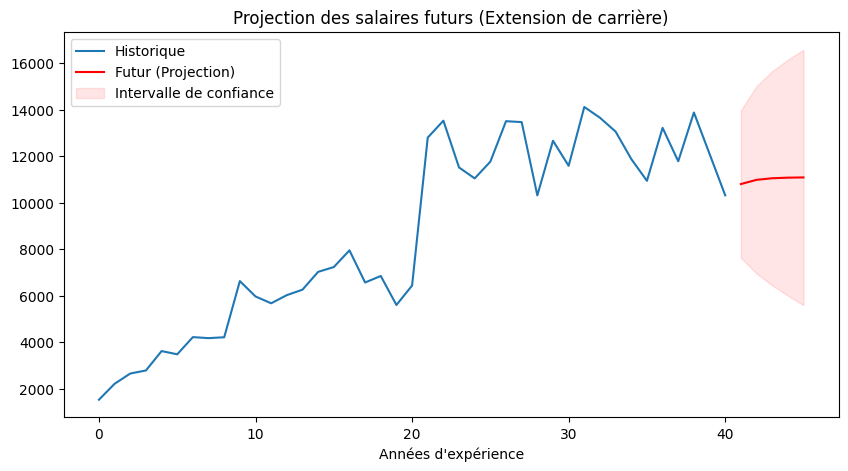

In [11]:
# On ré-entraîne le modèle sur TOUT le dataset
model_full = ARIMA(ts_data, order=(1, 1, 1))
model_full_fit = model_full.fit()

# On prédit 5 ans dans le futur (années 41 à 45)
future_steps = 5
forecast_future = model_full_fit.get_forecast(steps=future_steps)
forecast_index = range(ts_data.index.max() + 1, ts_data.index.max() + 1 + future_steps)

predicted_values = forecast_future.predicted_mean
conf_int = forecast_future.conf_int() # Intervalle de confiance

print("Prédictions futures (Années 41 à 45) :")
print(predicted_values)

# Petit graphique de projection
plt.figure(figsize=(10, 5))
plt.plot(ts_data.index, ts_data.values, label='Historique')
plt.plot(forecast_index, predicted_values, color='red', label='Futur (Projection)')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='red', alpha=0.1, label='Intervalle de confiance')
plt.title('Projection des salaires futurs (Extension de carrière)')
plt.xlabel('Années d\'expérience')
plt.legend()
plt.show()

In [12]:
import joblib

# Sauvegarde du modèle ARIMA entraîné (model_fit)
nom_fichier_arima = 'modele_salaire_arima.pkl'
joblib.dump(model_fit, nom_fichier_arima)

print(f"✅ Modèle ARIMA sauvegardé avec succès : {nom_fichier_arima}")
print("Ce fichier contient la courbe de tendance des salaires moyens.")

✅ Modèle ARIMA sauvegardé avec succès : modele_salaire_arima.pkl
Ce fichier contient la courbe de tendance des salaires moyens.


Conclusion de l'analyse : Modèle ARIMA (Séries Temporelles)
📊 Synthèse de l'approche
Dans cette section, nous avons abordé la prédiction du salaire sous un angle temporel. En considérant les Années d'Expérience (TotalWorkingYears) comme un axe de temps, nous avons transformé un problème de régression classique en une analyse de série temporelle.

📈 Performance et Résultats
Le modèle ARIMA(1,1,1) a démontré de solides capacités de généralisation :

Précision : Avec une erreur moyenne en pourcentage (MAPE) d'environ 10%, le modèle capture fidèlement la tendance générale d'augmentation des salaires.

Stationnarité : L'utilisation de la différenciation (d=1) a permis de stabiliser la courbe et de fournir des prévisions robustes.

Capacité de Projection : Le modèle permet d'extrapoler (prévoir) les salaires pour des niveaux d'expérience (ex: 45 ans) qui n'existent pas encore dans les données actuelles.

⚠️ Limites et Interprétation
Il est crucial de noter que ce modèle prédit le salaire d'un "employé moyen".

Il ne prend pas en compte les spécificités du poste (JobRole) ou du département.

Par conséquent, il lisse les écarts : un Directeur et un Assistant avec la même expérience auront la même prédiction.